In [40]:
import library as lib
import visualisation as viz

import string
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import swifter

from nltk.tokenize import casual_tokenize
from nltk.stem.porter import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score

from keras import layers
from keras import optimizers
from keras import models
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import backend as K




import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('Reviews.csv')

In [4]:
balanced_df = lib.resample_majority(df, 'Score', 5)

In [5]:
num_words = 20000
epochs = 10  
batch_size = 512  
sequence_len = 200  # Maximum number of words in a sequence
glove_dimensions = 200  # Number of dimensions of the GloVe word embeddings

In [7]:
balanced_df.Text = balanced_df.Text.apply(lib.remove_stopwords, join=True)

In [9]:
balanced_df.Text.head()

0    [I, bought, couple, packs, decaf, expiration, ...
1    [I, love, cat, food!, I, currently, four, cats...
2    [I've, tried, multiple, foods,, different, tim...
3    [My, dog, likes, time., The, dogs, I, tried, n...
4    [I, not, impressed, garlic, powder., The, garl...
Name: Text, dtype: object

In [10]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df.Text, balanced_df.Score, test_size=0.2, random_state=42)

In [11]:
tk = Tokenizer(num_words=num_words,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [12]:
X_train_seq[0]

[71, 46, 357, 2202, 14069, 374, 359, 69, 3817, 720, 2856, 27]

In [44]:
pickle.dump(tk, open( "tk_20k_vocab_200_words.pkl", "wb" ))

In [13]:
X_train_seq[7]

[28,
 362,
 21,
 1276,
 1,
 56,
 6315,
 17433,
 5,
 305,
 7576,
 4338,
 98,
 824,
 1276,
 389,
 336,
 2,
 26,
 203,
 4296,
 43,
 63,
 189,
 10242,
 4271,
 305,
 107,
 211,
 12067,
 752,
 305,
 141,
 203,
 189,
 4561,
 28,
 362,
 249,
 2175]

In [14]:
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=sequence_len)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=sequence_len)

In [15]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [16]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_pad, y_train_oh, test_size=0.1, random_state=37)

In [17]:
y_train_emb

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [18]:
X_train_emb[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     1,
         208,  1466, 11639,  9550,  9481,    28,    56,  1141,  6390,
          10,  2785,  1862,  2745,  1574,  1079,   430,   275,    56,
         677,  6815,  1959, 17550,   266,    38,  4771,    23,  8953,
         267,  2269,

## Training Proprietary Embeddings

In [19]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(num_words, 200, input_length=sequence_len))
emb_model.add(layers.Conv1D(32,
                            5,
                            activation='relu',
                            input_shape=(200,1)))
emb_model.add(layers.GlobalMaxPooling1D())
emb_model.add(layers.Dropout(0.2))
emb_model.add(layers.Dense(64,activation='relu',))
emb_model.add(layers.Dropout(0.2))
emb_model.add(layers.Dense(5, activation='softmax'))
emb_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=[metrics.categorical_accuracy, lib.f1_m, lib.precision_m, lib.recall_m])
emb_history = emb_model.fit(X_train_emb,
                            y_train_emb,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_valid_emb, y_valid_emb))


Train on 184798 samples, validate on 20534 samples
Epoch 1/10
184798/184798 [==============================] - 119s 646us/step - loss: 1.2422 - categorical_accuracy: 0.4770 - f1_m: 0.3066 - precision_m: 0.5910 - recall_m: 0.2207 - val_loss: 1.0173 - val_categorical_accuracy: 0.5870 - val_f1_m: 0.5092 - val_precision_m: 0.7309 - val_recall_m: 0.3909
Epoch 2/10
184798/184798 [==============================] - 119s 642us/step - loss: 0.9577 - categorical_accuracy: 0.6134 - f1_m: 0.5624 - precision_m: 0.7231 - recall_m: 0.4607 - val_loss: 0.9182 - val_categorical_accuracy: 0.6308 - val_f1_m: 0.5876 - val_precision_m: 0.7323 - val_recall_m: 0.4910
Epoch 3/10
184798/184798 [==============================] - 107s 576us/step - loss: 0.7914 - categorical_accuracy: 0.6916 - f1_m: 0.6662 - precision_m: 0.7722 - recall_m: 0.5861 - val_loss: 0.8831 - val_categorical_accuracy: 0.6566 - val_f1_m: 0.6384 - val_precision_m: 0.7394 - val_recall_m: 0.5618
Epoch 4/10
184798/184798 [======================

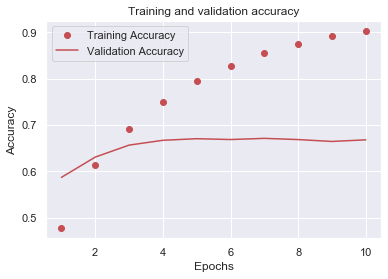

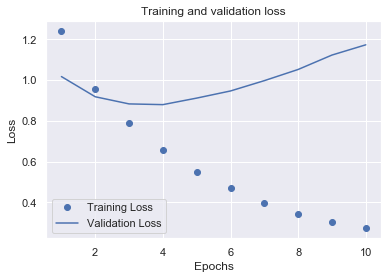

(None, None)

In [20]:
viz.plot_accuracy(emb_history), viz.plot_loss(emb_history)

In [21]:
emb_scores = lib.verbose_evaluate(emb_model, X_test_seq_pad, y_test_oh)

51333/51333 [==============================] - 9s 175us/step
The loss score is: 1.1864566502781062
The categorical_accuracy score is: 0.6670757532119751
The f1_m score is: 0.6684471368789673
The precision_m score is: 0.6915733218193054
The recall_m score is: 0.647527277469635


In [22]:
emb_model.save('conv_embedding_model_lrg.h5')

In [23]:
emb_adam_model = models.Sequential()
emb_adam_model.add(layers.Embedding(num_words, 200, input_length=sequence_len))
emb_adam_model.add(layers.Conv1D(16,
                                 5,
                                 activation='relu',
                                 input_shape=(200,1)))
emb_adam_model.add(layers.GlobalMaxPooling1D())
emb_adam_model.add(layers.Dropout(0.5))
emb_adam_model.add(layers.Dense(32,activation='relu',))
emb_adam_model.add(layers.Dropout(0.2))
emb_adam_model.add(layers.Dense(5, activation='softmax'))
emb_adam_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=[metrics.categorical_accuracy, lib.f1_m, lib.precision_m, lib.recall_m])
emb_adam_history = emb_adam_model.fit(X_train_emb,
                            y_train_emb,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_valid_emb, y_valid_emb))

Train on 184798 samples, validate on 20534 samples
Epoch 1/10
184798/184798 [==============================] - 97s 526us/step - loss: 1.3776 - categorical_accuracy: 0.4071 - f1_m: 0.1671 - precision_m: 0.4976 - recall_m: 0.1049 - val_loss: 1.1699 - val_categorical_accuracy: 0.5052 - val_f1_m: 0.2935 - val_precision_m: 0.7302 - val_recall_m: 0.1839
Epoch 2/10
184798/184798 [==============================] - 101s 548us/step - loss: 1.1651 - categorical_accuracy: 0.4994 - f1_m: 0.3797 - precision_m: 0.6457 - recall_m: 0.2693 - val_loss: 1.1016 - val_categorical_accuracy: 0.5445 - val_f1_m: 0.3996 - val_precision_m: 0.7229 - val_recall_m: 0.2763
Epoch 3/10
184798/184798 [==============================] - 99s 534us/step - loss: 1.0687 - categorical_accuracy: 0.5450 - f1_m: 0.4643 - precision_m: 0.6781 - recall_m: 0.3533 - val_loss: 1.0736 - val_categorical_accuracy: 0.5561 - val_f1_m: 0.4555 - val_precision_m: 0.7255 - val_recall_m: 0.3322
Epoch 4/10
184798/184798 [=========================

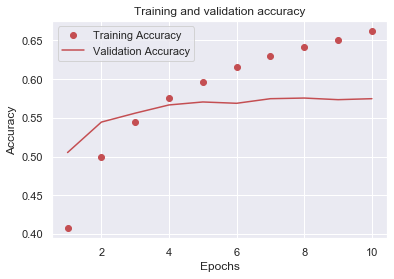

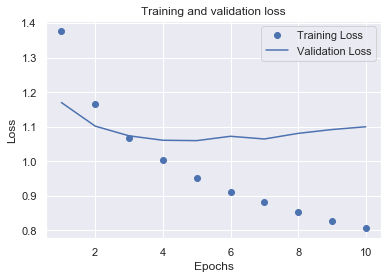

(None, None)

In [24]:
viz.plot_accuracy(emb_adam_history), viz.plot_loss(emb_adam_history)

In [25]:
emb_adam_scores = lib.verbose_evaluate(emb_adam_model, X_test_seq_pad, y_test_oh)

51333/51333 [==============================] - 7s 131us/step
The loss score is: 1.096676035371201
The categorical_accuracy score is: 0.5767829418182373
The f1_m score is: 0.527244508266449
The precision_m score is: 0.7040293216705322
The recall_m score is: 0.42490652203559875


### Comparison of the two models

In [26]:
emb_scores = list(emb_scores.values())
emb_adam_scores = list(emb_adam_scores.values())
loss = [emb_scores[0], emb_adam_scores[0]]
categorical_accuracy = [emb_scores[1], emb_adam_scores[1]]
f1 = [emb_scores[2], emb_adam_scores[2]]
precision = [emb_scores[3], emb_adam_scores[3]]
recall = [emb_scores[4], emb_adam_scores[4]]

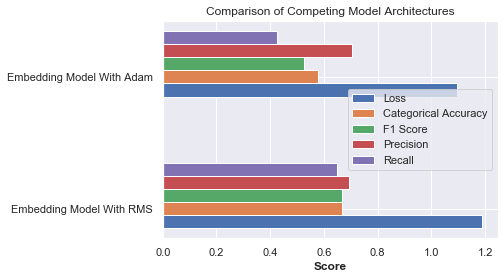

In [36]:
barWidth = 0.1

# Set position of bar on X axis
r1 = np.arange(len(loss))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.barh(r1, loss, height=barWidth, edgecolor='white', label='Loss')
plt.barh(r2, categorical_accuracy, height=barWidth, edgecolor='white', label='Categorical Accuracy')
plt.barh(r3, f1, height=barWidth, edgecolor='white', label='F1 Score')
plt.barh(r4, precision, height=barWidth, edgecolor='white', label='Precision')
plt.barh(r5, recall, height=barWidth, edgecolor='white', label='Recall')
 
# Add xticks on the middle of the group bars
plt.xlabel('Score', fontweight='bold')
plt.title('Comparison of Competing Model Architectures')
plt.yticks([r + barWidth for r in range(len(loss))], ['Embedding Model With RMS', 'Embedding Model With Adam',])
 
# Create legend & Show graphic
plt.legend()
plt.show()

## Previous Modelling Approach

In [5]:
%%time
stemmer = PorterStemmer()
corpus = [casual_tokenize(doc.lower()) for doc in df.Text]
corpus_sw = [lib.remove_stopwords(doc) for doc in corpus]
stemmed_corpus = []
for doc in corpus_sw:
    stemmed_corpus.append([stemmer.stem(word) for word in doc])

CPU times: user 1min 51s, sys: 1.01 s, total: 1min 52s
Wall time: 1min 59s


In [6]:
def dummy_func(doc):
    return doc

vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                             tokenizer=dummy_func, 
                             preprocessor=dummy_func, 
                             max_features=8000)
wv = vectorizer.fit_transform(stemmed_corpus)    

In [7]:
wv.shape[0] == len(df)

True

In [8]:
dense_wv = wv.toarray()
feature_names = vectorizer.vocabulary_
sorted_features = {k: v for k, v in sorted(feature_names.items(), key=lambda item: item[1])}
wv_df = pd.DataFrame(dense_wv, columns = sorted_features.keys())
wv_df['Target'] = df.Score

In [9]:
def to_one_hot(labels, dimension=5):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label-1] = 1
    return results

In [10]:
X = wv_df.drop(columns='Target', axis=1)
y = wv_df.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

one_hot_train_labels = to_one_hot(y_train)
one_hot_test_labels = to_one_hot(y_test)

In [11]:
one_hot_train_labels[0]

array([0., 0., 1., 0., 0.])

In [12]:
x_val = X_train[:6800]
partial_x_train = X_train[6800:]
y_val = one_hot_train_labels[:6800]
partial_y_train = one_hot_train_labels[6800:]

In [13]:
print(partial_x_train.shape,partial_y_train.shape)
print(X_test.shape,one_hot_test_labels.shape)

(61294, 8000) (61294, 5)
(22699, 8000) (22699, 5)


In [14]:
partial_x_train.shape[1]

8000

In [15]:
simple_nn = models.Sequential()
simple_nn.add(layers.Dense(32, activation='relu', input_shape = (partial_x_train.shape[1], )))
simple_nn.add(layers.Dropout(0.4))
simple_nn.add(layers.Dense(32, activation='relu'))
simple_nn.add(layers.Dropout(0.25))
simple_nn.add(layers.Dense(5, activation='softmax'))

In [16]:
simple_nn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics = [metrics.categorical_accuracy])

In [17]:
nn_history = simple_nn.fit(partial_x_train,
                        partial_y_train,
                        epochs=10,
                        batch_size=512,
                        validation_data=(x_val, y_val))


Train on 61294 samples, validate on 6800 samples
Epoch 1/10
61294/61294 [==============================] - 12s 198us/step - loss: 1.4929 - categorical_accuracy: 0.3669 - val_loss: 1.3014 - val_categorical_accuracy: 0.4459
Epoch 2/10
61294/61294 [==============================] - 8s 128us/step - loss: 1.2099 - categorical_accuracy: 0.4962 - val_loss: 1.1253 - val_categorical_accuracy: 0.5316
Epoch 3/10
61294/61294 [==============================] - 8s 130us/step - loss: 1.0921 - categorical_accuracy: 0.5495 - val_loss: 1.0889 - val_categorical_accuracy: 0.5474
Epoch 4/10
61294/61294 [==============================] - 9s 141us/step - loss: 1.0285 - categorical_accuracy: 0.5799 - val_loss: 1.0797 - val_categorical_accuracy: 0.5537
Epoch 5/10
61294/61294 [==============================] - 9s 154us/step - loss: 0.9886 - categorical_accuracy: 0.6005 - val_loss: 1.0795 - val_categorical_accuracy: 0.5560
Epoch 6/10
61294/61294 [==============================] - 10s 164us/step - loss: 0.9489 -